# Preprocessing of IRefIndex protein-protein interaction network
Refer to the work of EMOGI [LINK](https://github.com/schulter/EMOGI/tree/master).
This notebook processes the raw [IRefIndex](http://irefindex.org/wiki/index.php?title=iRefIndex) PPI network downloaded from [here](https://irefindex.vib.be/wiki/index.php/README_MITAB2.6_for_iRefIndex_20.0). I used the release `v20.0` for the analysis.

Preprocessing involved:

* Selecting only binary interactions (and no self-interactions)
* Selecting only human interactions
* Converting IDs to ensembl IDs and hugo gene symbols

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import mygene
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
IREF_interactions = pd.read_csv('9606.mitab.08-28-2023.txt',sep='\t') # v20

In [4]:
IREF_interactions.head()

,#uidA,uidB,altA,altB,aliasA,aliasB,method,author,pmids,taxa,...,irigid,crogida,crogidb,crigid,icrogida,icrogidb,icrigid,imex_id,edgetype,numParticipants
0,complex:+++YPUW/IFXLBjMl6tjRQInYg6Y,uniprotkb:Q04725,rogid:+++YPUW/IFXLBjMl6tjRQInYg6Y,entrezgene/locuslink:7089|refseq:NP_003251|uni...,crogid:tSBu4bq/CzOghhxkRgOVe/WBUD8|icrogid:283...,hgnc:TLE2|uniprotkb:TLE2_HUMAN|crogid:QlgGABrH...,"psi-mi:""MI:0007""(anti tag coimmunoprecipitation)",Huttlin et al. (2017),pubmed:10.1038/nature22366|pubmed:28514442,-,...,2463646,tSBu4bq/CzOghhxkRgOVe/WBUD8,QlgGABrHV/Wi5v8Pb3SQAq+1gTU9606,tSBu4bq/CzOghhxkRgOVe/WBUD8,2834642,3724222,2834642,imex:IM-25778-9303,C,7
1,complex:+++YPUW/IFXLBjMl6tjRQInYg6Y,uniprotkb:Q04725,rogid:+++YPUW/IFXLBjMl6tjRQInYg6Y,entrezgene/locuslink:7089|refseq:NP_003251|uni...,crogid:tSBu4bq/CzOghhxkRgOVe/WBUD8|icrogid:283...,hgnc:TLE2|uniprotkb:TLE2_HUMAN|crogid:QlgGABrH...,"psi-mi:""MI:0007""(anti tag coimmunoprecipitation)",Huttlin et al. (2017),pubmed:10.1038/nature22366|pubmed:28514442,-,...,2463646,tSBu4bq/CzOghhxkRgOVe/WBUD8,QlgGABrHV/Wi5v8Pb3SQAq+1gTU9606,tSBu4bq/CzOghhxkRgOVe/WBUD8,2834642,3724222,2834642,imex:IM-25778-9303,C,7
2,complex:+++YPUW/IFXLBjMl6tjRQInYg6Y,uniprotkb:Q04725,rogid:+++YPUW/IFXLBjMl6tjRQInYg6Y,entrezgene/locuslink:7089|refseq:NP_003251|uni...,crogid:tSBu4bq/CzOghhxkRgOVe/WBUD8|icrogid:283...,hgnc:TLE2|uniprotkb:TLE2_HUMAN|crogid:QlgGABrH...,"psi-mi:""MI:0007""(anti tag coimmunoprecipitation)",huttlin-2017-3,pubmed:28514442,-,...,2463646,tSBu4bq/CzOghhxkRgOVe/WBUD8,QlgGABrHV/Wi5v8Pb3SQAq+1gTU9606,tSBu4bq/CzOghhxkRgOVe/WBUD8,2834642,3724222,2834642,-,C,7
3,complex:+++YPUW/IFXLBjMl6tjRQInYg6Y,uniprotkb:Q08117,rogid:+++YPUW/IFXLBjMl6tjRQInYg6Y,entrezgene/locuslink:166|refseq:NP_001121|unip...,crogid:tSBu4bq/CzOghhxkRgOVe/WBUD8|icrogid:283...,hgnc:TLE5|uniprotkb:TLE5_HUMAN|crogid:eveYX2Rj...,"psi-mi:""MI:0007""(anti tag coimmunoprecipitation)",Huttlin et al. (2017),pubmed:10.1038/nature22366|pubmed:28514442,-,...,2463646,tSBu4bq/CzOghhxkRgOVe/WBUD8,eveYX2Rj6Oz431E8nGcTk4bUNt89606,tSBu4bq/CzOghhxkRgOVe/WBUD8,2834642,1795878,2834642,imex:IM-25778-9303,C,7
4,complex:+++YPUW/IFXLBjMl6tjRQInYg6Y,uniprotkb:Q08117,rogid:+++YPUW/IFXLBjMl6tjRQInYg6Y,entrezgene/locuslink:166|refseq:NP_001121|unip...,crogid:tSBu4bq/CzOghhxkRgOVe/WBUD8|icrogid:283...,hgnc:TLE5|uniprotkb:TLE5_HUMAN|crogid:eveYX2Rj...,"psi-mi:""MI:0007""(anti tag coimmunoprecipitation)",Huttlin et al. (2017),pubmed:10.1038/nature22366|pubmed:28514442,-,...,2463646,tSBu4bq/CzOghhxkRgOVe/WBUD8,eveYX2Rj6Oz431E8nGcTk4bUNt89606,tSBu4bq/CzOghhxkRgOVe/WBUD8,2834642,1795878,2834642,imex:IM-25778-9303,C,7


In [5]:
IREF_binary_interactions = IREF_interactions[IREF_interactions.edgetype == 'X'] # only binary and non-self interactions
IREF_humanbinary = IREF_binary_interactions[IREF_binary_interactions.taxa == 'taxid:9606(Homo sapiens)'] # only human interactions
IREF_humanbinary['#uidA'].head()

1244531    refseq:NP_000087
1244532    refseq:NP_000087
1244533    refseq:NP_000087
1244534    refseq:NP_000087
1244535    refseq:NP_000087
Name: #uidA, dtype: object

In [6]:
def get_gene_symbols_for_IREF(list_of_ensembl_ids):
    # get Ensembl IDs for gene names
    mg = mygene.MyGeneInfo()
    res = mg.querymany(list_of_ensembl_ids,
                       scopes='refseq,symbol,entrezgene,reporter,uniprot',
                       fields='symbol',
                       species='human', returnall=True
                      )

    def get_symbol_and_ensembl(d):
        if 'symbol' in d:
            return [d['query'], d['symbol']]
        else:
            return [d['query'], None]

    node_names = [get_symbol_and_ensembl(d) for d in res['out']]
    # now, retrieve the names and IDs from a dictionary and put in DF
    node_names = pd.DataFrame(node_names, columns=['Ensembl_ID', 'Symbol']).set_index('Ensembl_ID')
    node_names.dropna(axis=0, inplace=True)
    return node_names

all_ids = IREF_humanbinary['#uidA'].append(IREF_humanbinary.uidB).unique()
all_ids = [i.split(':')[1] for i in all_ids] # remove the trailing database where the interaction comes from
iref_id_mapping = get_gene_symbols_for_IREF(all_ids)

153 input query terms found dup hits:	[('A0A0A0MQZ8', 2), ('A0A0F7RQP8', 3), ('A0A140VK21', 2), ('A0A894JZ42', 2), ('A4FTV9', 5), ('A5PLL7
22274 input query terms found no hit:	['NP_000655', 'NP_001003725', 'NP_001004326', 'NP_001004330', 'NP_001007237', 'NP_001010845', 'NP_00


In [7]:
IREF_humanbinary['#uidA'] = [i[1] for i in IREF_humanbinary['#uidA'].str.split(':')]
IREF_humanbinary['uidB'] = [i[1] for i in IREF_humanbinary['uidB'].str.split(':')]
p1_incl = IREF_humanbinary.join(iref_id_mapping, on='#uidA', how='inner', rsuffix='_p1')
both_incl = p1_incl.join(iref_id_mapping, on='uidB', how='inner', rsuffix='_p2')
both_incl.head()

D:\devtool\Anaconda3\envs\EMOGI-tf\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\devtool\Anaconda3\envs\EMOGI-tf\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,#uidA,uidB,altA,altB,aliasA,aliasB,method,author,pmids,taxa,...,crogidb,crigid,icrogida,icrogidb,icrigid,imex_id,edgetype,numParticipants,Symbol,Symbol_p2
1244533,NP_000087,XP_016872359,entrezgene/locuslink:1356|refseq:NP_000087|rog...,entrezgene/locuslink:8945|refseq:XP_016872359|...,hgnc:CP|crogid:bPuhUo8h0DvtcwLufTOOHxrl9NI9606...,hgnc:BTRC|crogid:9/bXDY6YvJWvP6iMSgOPT9CNGAE96...,"psi-mi:""MI:0018""(two hybrid)",Wang J (2011),pubmed:21988832,taxid:9606(Homo sapiens),...,9/bXDY6YvJWvP6iMSgOPT9CNGAE9606,yVkqfbjzKIt1jC4TkEtmkYbsjMY,1272179,910608,1525014,-,X,2,CP,BTRC
1251464,NP_001307840,XP_016872359,entrezgene/locuslink:840|refseq:NP_001307840|r...,entrezgene/locuslink:8945|refseq:XP_016872359|...,hgnc:CASP7|crogid:XcSWtfWWnuOKIbAR+TXpkCq5fig9...,hgnc:BTRC|crogid:9/bXDY6YvJWvP6iMSgOPT9CNGAE96...,"psi-mi:""MI:0004""(affinity chromatography techn...",Huttlin EL (2021),pubmed:33961781,taxid:9606(Homo sapiens),...,9/bXDY6YvJWvP6iMSgOPT9CNGAE9606,SpNxKl0eHJQHA1x+4/odD4kdSrM,4835623,910608,3640611,-,X,2,CASP7,BTRC
1256142,NP_001311434,XP_016872359,entrezgene/locuslink:387893|refseq:NP_00131143...,entrezgene/locuslink:8945|refseq:XP_016872359|...,hgnc:KMT5A|crogid:/0hb5/U7CI+EUSMe0fB1JfXa5zo9...,hgnc:BTRC|crogid:9/bXDY6YvJWvP6iMSgOPT9CNGAE96...,"psi-mi:""MI:0004""(affinity chromatography techn...",Wang Z (2015),pubmed:26666832,taxid:9606(Homo sapiens),...,9/bXDY6YvJWvP6iMSgOPT9CNGAE9606,fJlH+zEDbEHC6XCC5zi1fz++K/c,5397363,910608,3249124,-,X,2,KMT5A,BTRC
1256143,NP_001311434,XP_016872359,entrezgene/locuslink:387893|refseq:NP_00131143...,entrezgene/locuslink:8945|refseq:XP_016872359|...,hgnc:KMT5A|crogid:/0hb5/U7CI+EUSMe0fB1JfXa5zo9...,hgnc:BTRC|crogid:9/bXDY6YvJWvP6iMSgOPT9CNGAE96...,"psi-mi:""MI:0004""(affinity chromatography techn...",Wang Z (2015),pubmed:26666832,taxid:9606(Homo sapiens),...,9/bXDY6YvJWvP6iMSgOPT9CNGAE9606,fJlH+zEDbEHC6XCC5zi1fz++K/c,5397363,910608,3249124,-,X,2,KMT5A,BTRC
1256144,NP_001311434,XP_016872359,entrezgene/locuslink:387893|refseq:NP_00131143...,entrezgene/locuslink:8945|refseq:XP_016872359|...,hgnc:KMT5A|crogid:/0hb5/U7CI+EUSMe0fB1JfXa5zo9...,hgnc:BTRC|crogid:9/bXDY6YvJWvP6iMSgOPT9CNGAE96...,"psi-mi:""MI:0004""(affinity chromatography techn...",Wang Z (2015),pubmed:26666832,taxid:9606(Homo sapiens),...,9/bXDY6YvJWvP6iMSgOPT9CNGAE9606,fJlH+zEDbEHC6XCC5zi1fz++K/c,5397363,910608,3249124,-,X,2,KMT5A,BTRC


In [6]:
IREF_ppi_final = both_incl[['Symbol', 'Symbol_p2']]
IREF_ppi_final['confidence'] = 1
IREF_ppi_final.columns = ['partner1', 'partner2', 'confidence']
IREF_ppi_final.head()

D:\devtool\Anaconda3\envs\EMOGI-tf\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,partner1,partner2,confidence
1244533,CP,BTRC,1
1251464,CASP7,BTRC,1
1256142,KMT5A,BTRC,1
1256143,KMT5A,BTRC,1
1256144,KMT5A,BTRC,1


In [7]:
num_duplicated_edges = IREF_ppi_final.duplicated(subset=['partner1', 'partner2']).sum()
IREF_ppi_final.drop_duplicates(subset=['partner1', 'partner2'], inplace=True)
print ("Duplicated Edges: {} -> New #Edges: {}".format(num_duplicated_edges,
                                                       IREF_ppi_final.shape[0]))

Duplicated Edges: 1085348 -> New #Edges: 608165


D:\devtool\Anaconda3\envs\EMOGI-tf\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
G = nx.from_pandas_edgelist(IREF_ppi_final, source='partner1', target='partner2', edge_attr='confidence')
G.remove_edges_from(nx.selfloop_edges(G))
G.remove_nodes_from(list(nx.isolates(G)))
adj_pd = nx.to_pandas_adjacency(G)
adjacency_matrix = adj_pd.values
node_names = adj_pd.index.values

avg_node_degree = np.mean([value for key, value in G.degree()])
print ("Constructed Adjacency Matrix with average node degree of: {}".format(avg_node_degree))
print ("Adjacency matrix has {} edges and {} nodes in total".format(G.number_of_edges(), G.number_of_nodes()))

Constructed Adjacency Matrix with average node degree of: 69.33348891481914
Adjacency matrix has 594188 edges and 17140 nodes in total


In [34]:
edgelist_no_repeat = nx.to_pandas_edgelist(G)
edgelist_no_repeat.columns=['partner1','partner2','confidence'] # rename columns names
edgelist_no_repeat.to_csv('IREF_symbols_no_repeat.tsv',sep='\t',index=False)
edgelist_no_repeat

,partner1,partner2,confidence
0,CP,BTRC,1
1,CP,GDPD1,1
2,CP,APOA1,1
3,CP,SOX2,1
4,CP,HBB,1
...,...,...,...
594183,TPO,DIO1,1
594184,CHM,RABGGTA,1
594185,TNFRSF4,TNFSF4,1
594186,VCPKMT,ALKBH6,1


In [23]:
G.degree

DegreeView({'CP': 48, 'BTRC': 603, 'CASP7': 67, 'KMT5A': 77, 'USP54': 161, 'ENO1': 303, 'NPM1': 910, 'TRA2A': 219, 'EP300': 1120, 'UFD1': 115, 'MTSS1': 23, 'LRRC49': 66, 'AEBP2': 40, 'DDX3X': 425, 'HNRNPH1': 451, 'ADAR': 212, 'USP33': 96, 'RPRD2': 117, 'TRIM9': 65, 'DBN1': 279, 'RELA': 421, 'SMAD3': 263, 'INKA1': 21, 'UBAP2L': 184, 'PHF19': 68, 'IGF2BP1': 259, 'WSB1': 15, 'PHF8': 151, 'STARD8': 69, 'WWC1': 77, 'WASHC2A': 69, 'NOLC1': 229, 'YAP1': 614, 'HNRNPM': 528, 'GSK3B': 717, 'MRPS18A': 100, 'MAP3K7': 312, 'MKI67': 481, 'CTTN': 287, 'LDHB': 216, 'SUZ12': 493, 'IL12RB1': 63, 'NOL10': 120, 'CHPF': 43, 'CCDC50': 46, 'MAPK14': 213, 'EZH2': 631, 'HIPK2': 63, 'FAM120A': 235, 'NEDD4': 360, 'BRD7': 505, 'MYBBP1A': 339, 'GPATCH8': 86, 'NPLOC4': 127, 'SNRNP70': 709, 'UHRF1': 162, 'HDGFL2': 153, 'PCMT1': 177, 'HSP90AA1': 968, 'CEP55': 187, 'GBF1': 278, 'UBE4B': 90, 'BCL10': 95, 'TUBGCP5': 96, 'CEP170': 209, 'FUS': 545, 'STIL': 133, 'DAP3': 246, 'IGF2BP2': 182, 'DLG1': 227, 'WTAP': 150, 'CPVL'

D:\devtool\Anaconda3\envs\EMOGI-tf\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Node Degree Distribution of Genes in PPI')

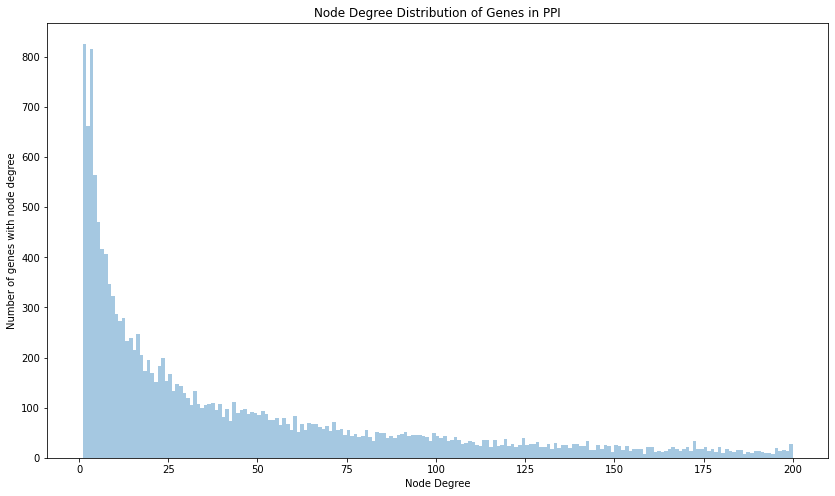

In [24]:
node_degrees = np.array([i[1] for i in list(G.degree())])
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(1, 200, 200)

sns.distplot(node_degrees, kde=False, bins=bins) 

#ax = plt.hist(node_degrees, bins)
plt.xlabel('Node Degree')
plt.ylabel('Number of genes with node degree')
plt.title('Node Degree Distribution of Genes in PPI')

In [25]:
df=pd.DataFrame(node_degrees,columns=['node degree'])
df.describe().astype(int)

,node degree
count,17140
mean,69
std,122
min,1
25%,8
50%,28
75%,83
max,3099
